In [1]:
from pathlib import Path

%matplotlib widget 
import matplotlib.pyplot as plt

import pandas as pd
import lightkurve as lk
from uncertainties import ufloat

In [2]:
# The following are good for clear primary & secondary eclipses and detrending through flattening;
# TIC141685465, TIC167692429, TIC307488184. TIC355152640, TIC382517745, TIC260132330

# TIC300560295 shows flattening removing pulsations but the secondary is not clear

# TIC308851582 looks like the analysis hasn't picked up the secondary correctly
# TIC341193555 - wrong secondary eclipse

# TIC350518984 has zero eclipse widths - also cannot see a secondary
# TIC372909935 has zero eclipse widths

# TIC031273263 - look into where the secondary is

# TIC309658221 - noisy but analysis should work

# TIC140659980 has good eclipses and potentially interesting residuals

# TIC167692429 - some variability in eclipse timings 
target = "TIC055497281"
flux_column = "pdcsap_flux"
quality_bitmask = "hardest"
sectors = []
eclipse_dur_multiple = 1.

input_file = Path(".") / "tessebs_extra.csv"

In [3]:
def read_ufloat(summary, nom_key, err_key=None) -> ufloat:
    """ Read a value and errorbar from the summary into a ufloat. """
    nom = summary.loc[nom_key]["val"] if nom_key in summary.index else 0
    if not err_key:
        err_key = nom_key + "_err"
    err = abs(summary.loc[err_key]["val"] if err_key in summary.index else 0)
    return ufloat(nom, err)

Analysis Log:
2024-03-15 23:54:15 INFO main_functions - analyse_light_curve: Start of analysis
2024-03-16 02:32:49 INFO main_functions - analyse_frequencies: Frequency extraction done. Total time elapsed: 9513.8s.
2024-03-16 03:18:14 INFO main_functions - analyse_harmonics: Harmonic analysis done. Total time elapsed: 2725.2s.
2024-03-16 06:11:37 INFO main_functions - analyse_light_curve: End of analysis. Total time elapsed: 22642.3s.

From analysis summary
Reference time:          2232.103445+/-0
Orbital period:          14.905379+/-0.000005
Reference clipse times:  2233.239683+/-0.000393, 2240.111786+/-0.000442
Eclipse durations:       0.247638+/-0.000786, 0.357789+/-0.000884

Loaded 34 light curve fits file(s) for TIC055497281.
Sector 001...normalizing...creating mask...flattening...done.


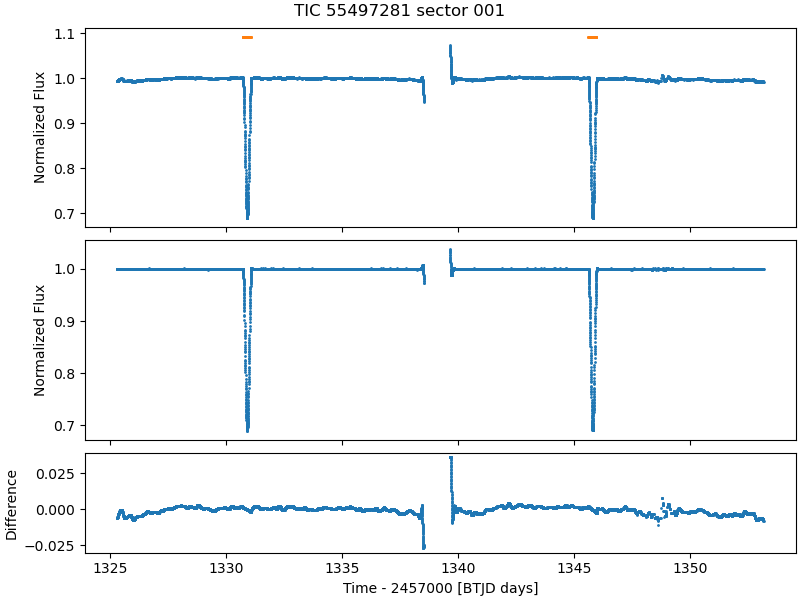

Sector 002...normalizing...creating mask...flattening...done.


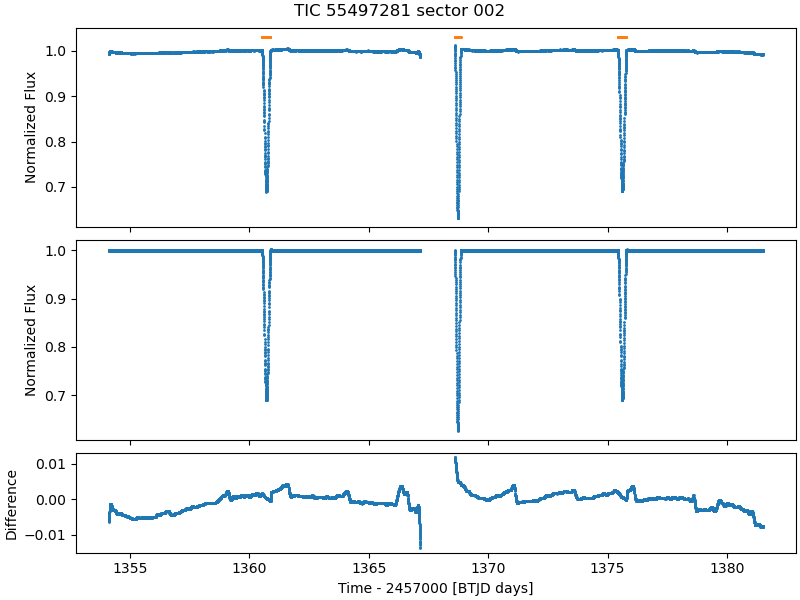

Sector 003...normalizing...creating mask...flattening...done.


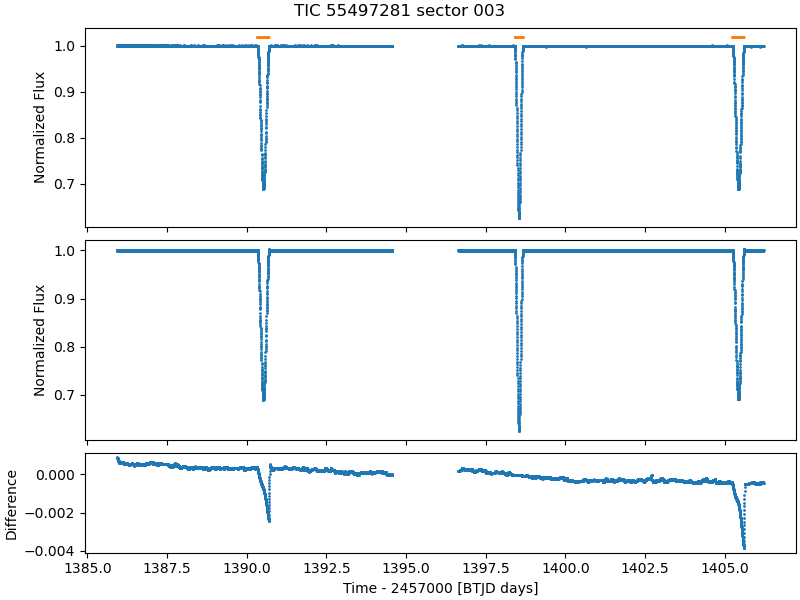

Sector 004...normalizing...creating mask...flattening...done.


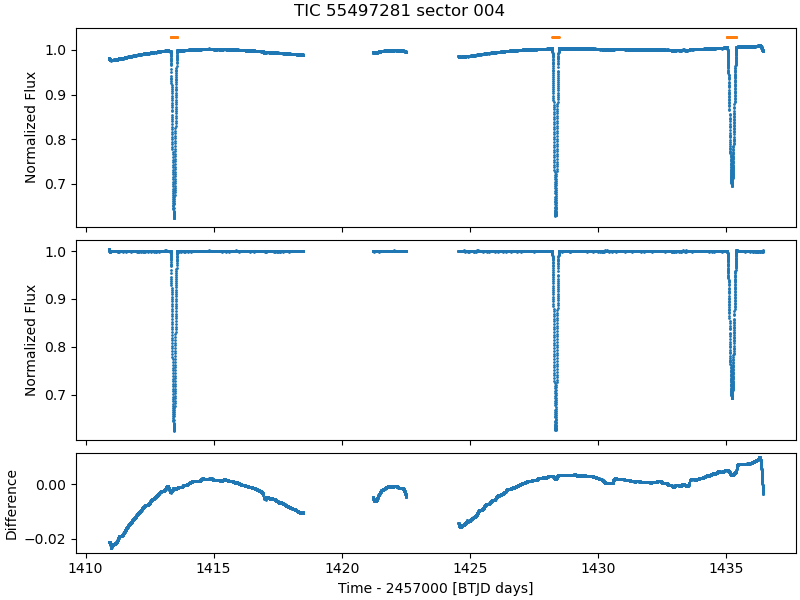

Sector 005...normalizing...creating mask...flattening...done.


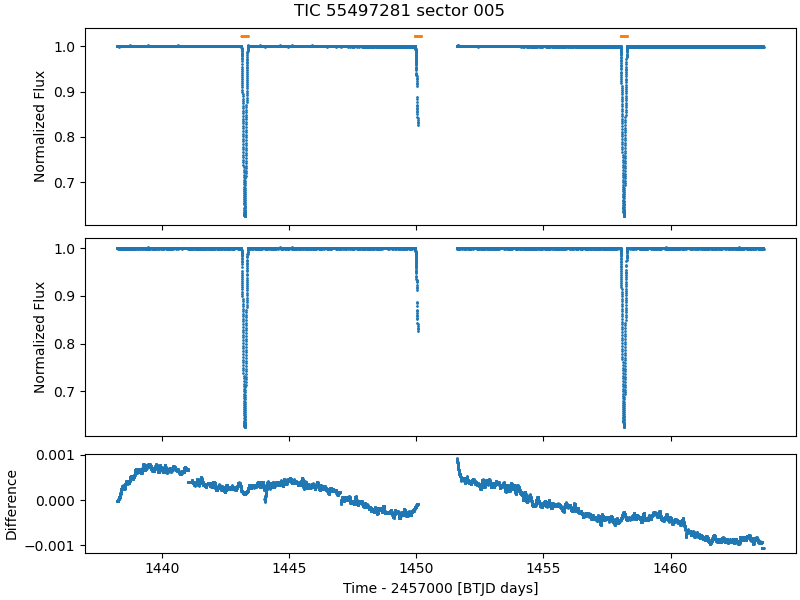

Sector 006...normalizing...creating mask...flattening...done.


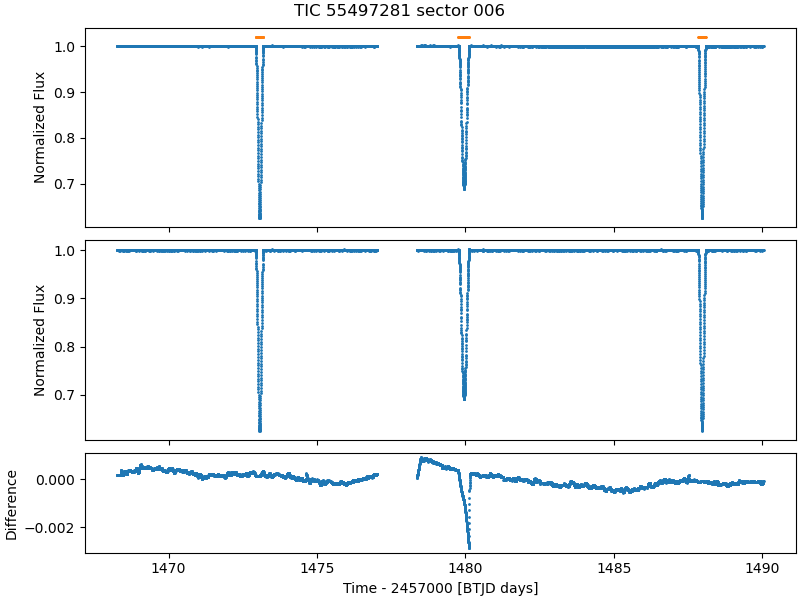

Sector 008...normalizing...creating mask...flattening...done.


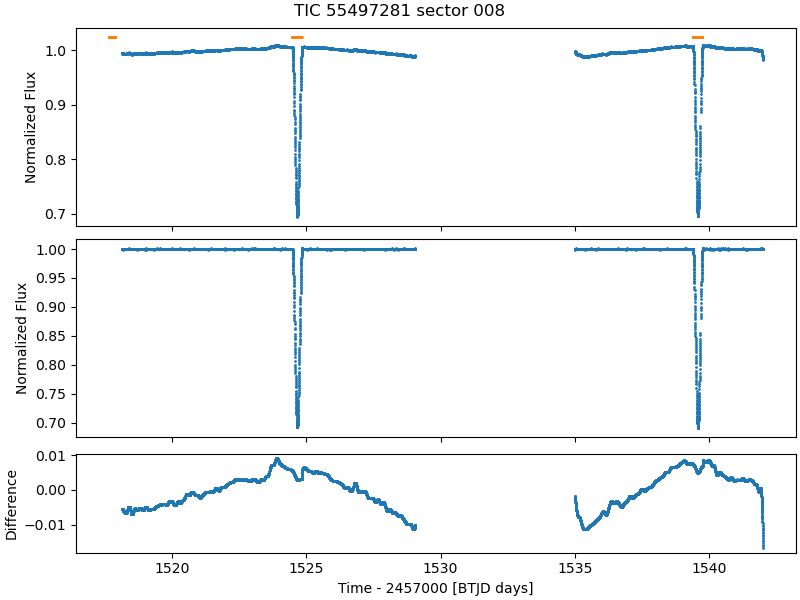

Sector 009...normalizing...creating mask...flattening...done.


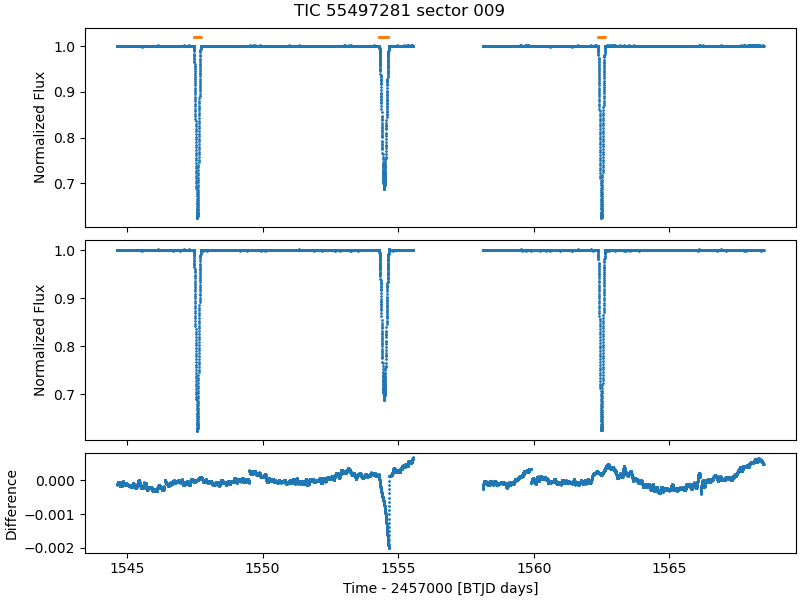

Sector 010...normalizing...creating mask...flattening...done.


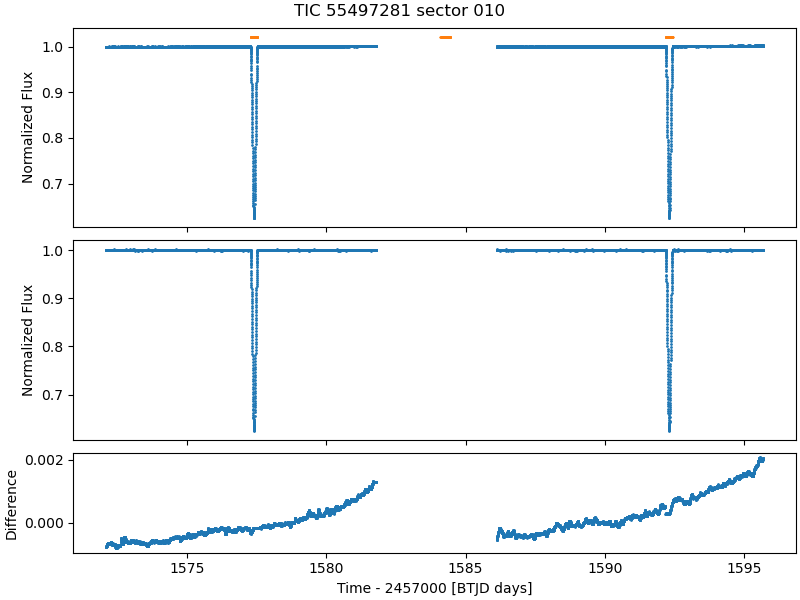

Sector 011...normalizing...creating mask...flattening...done.


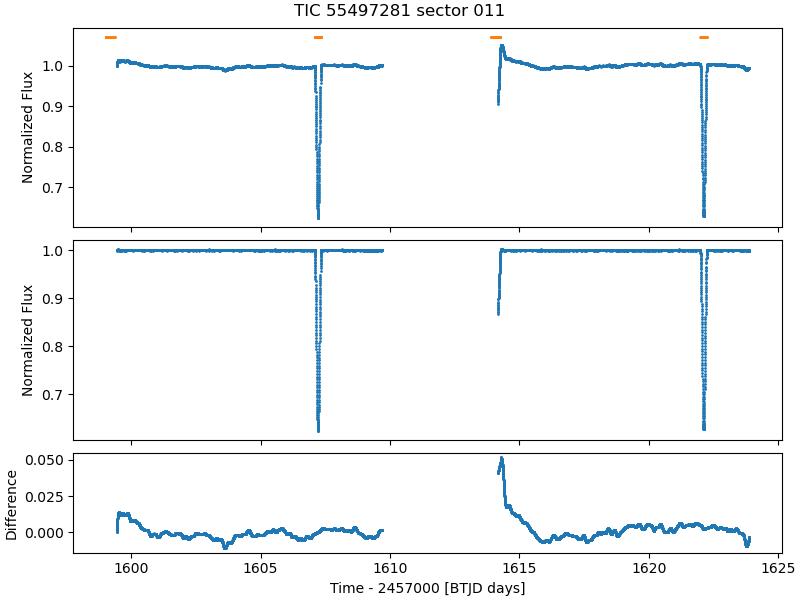

Sector 012...normalizing...creating mask...flattening...done.


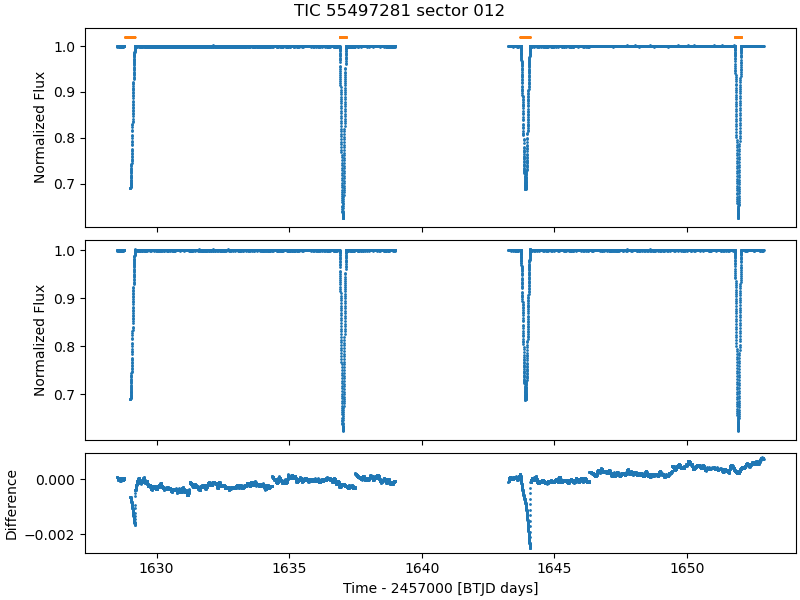

Sector 013...normalizing...creating mask...flattening...done.


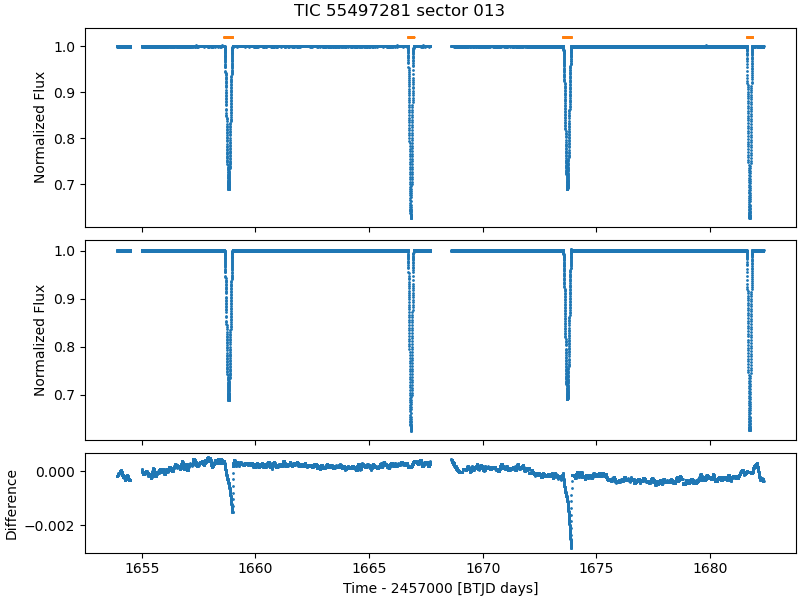

Sector 027...normalizing...creating mask...flattening...done.


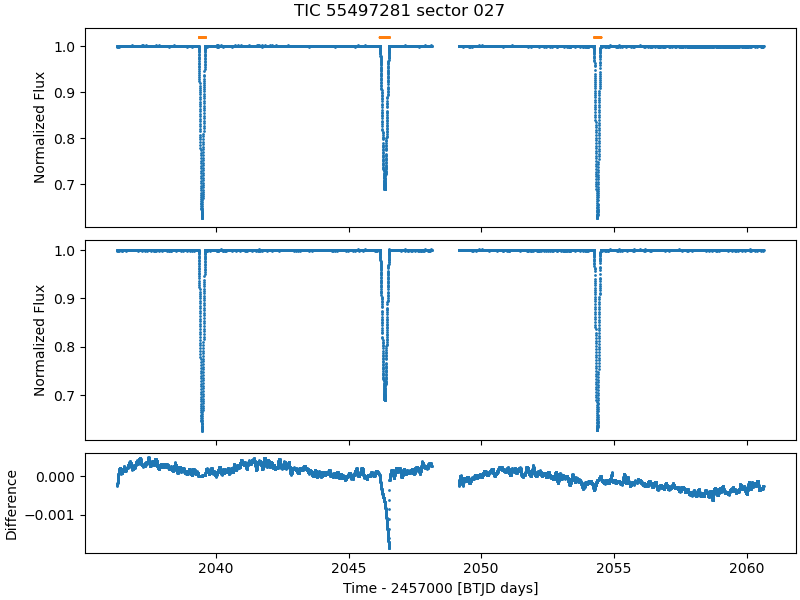

Sector 028...normalizing...creating mask...flattening...done.


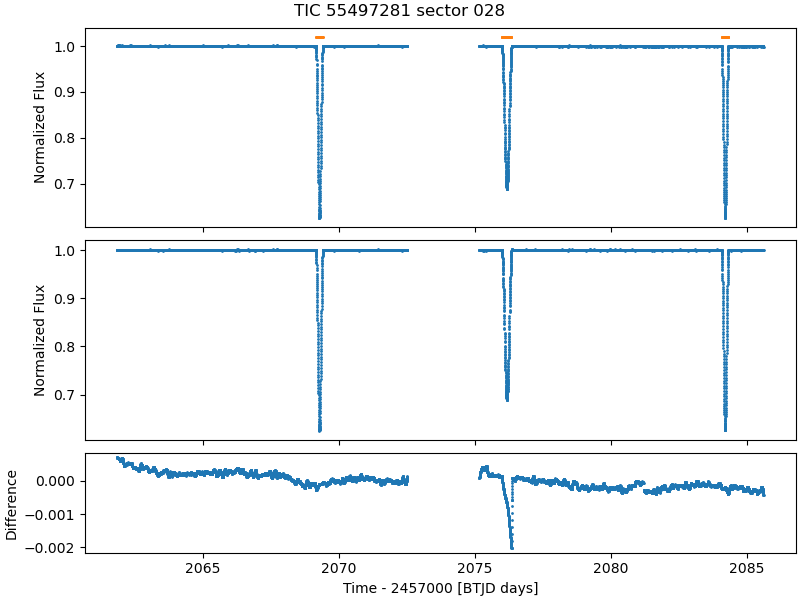

Sector 029...normalizing...creating mask...flattening...done.


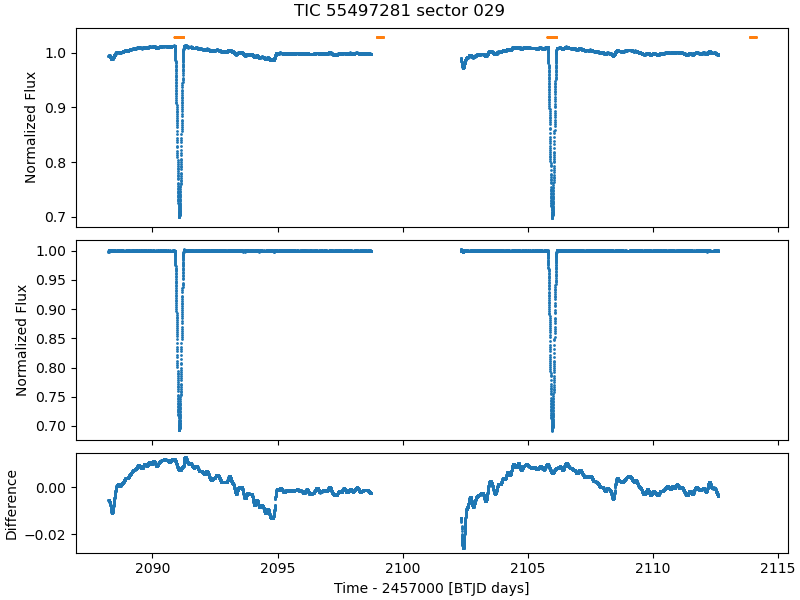

Sector 030...normalizing...creating mask...flattening...done.


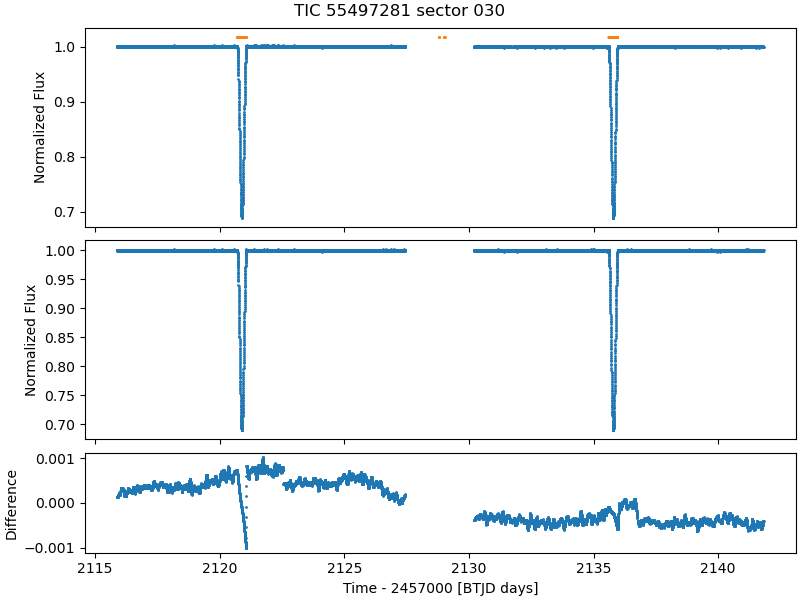

Sector 031...normalizing...creating mask...flattening...done.


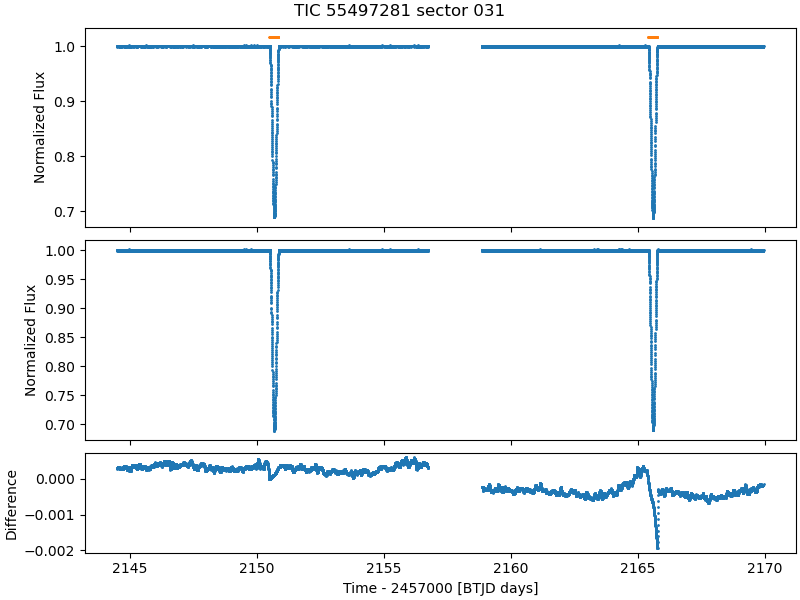

Sector 032...normalizing...creating mask...flattening...done.


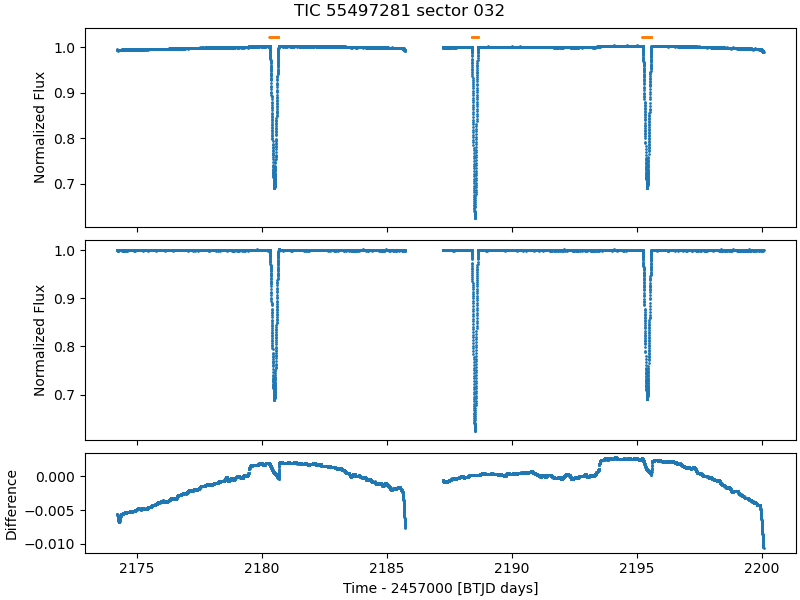

Sector 033...normalizing...creating mask...flattening...done.


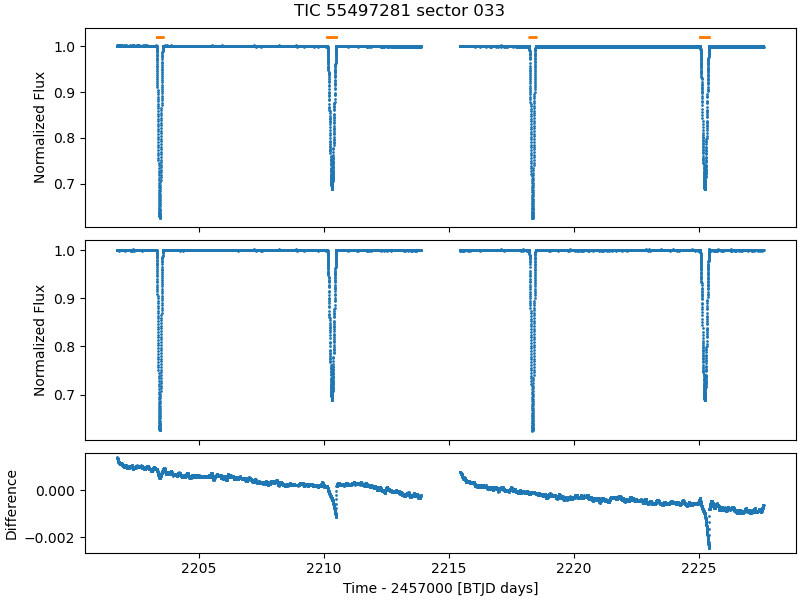

Sector 034...normalizing...creating mask...flattening...done.


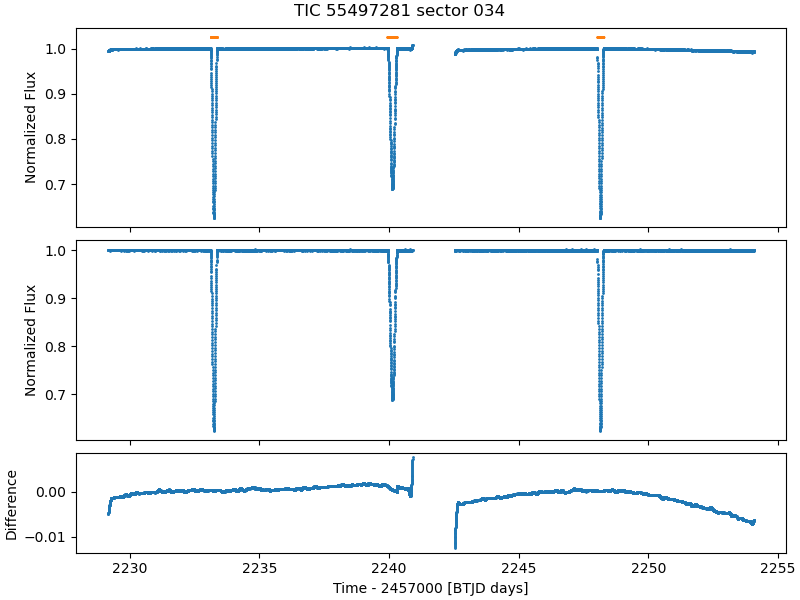

Sector 035...normalizing...creating mask...flattening...done.


/home/steveo/anaconda3/envs/platodebs/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


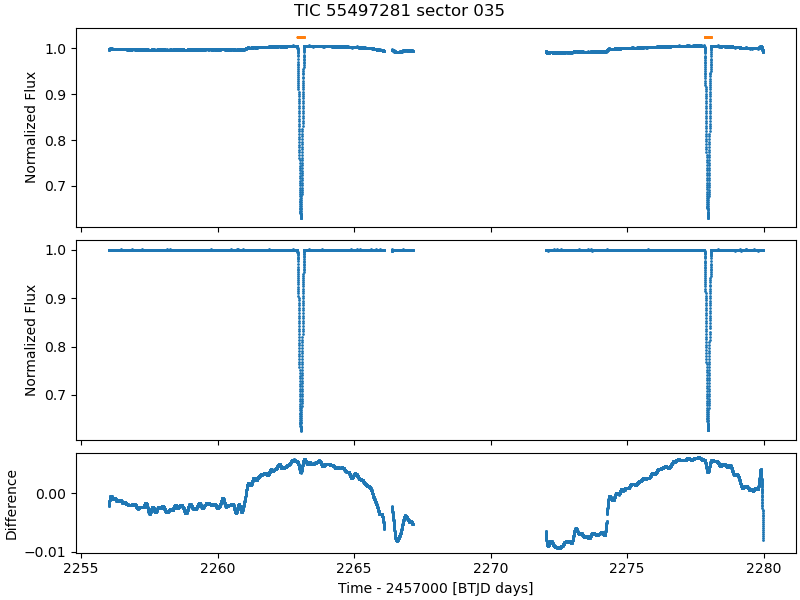

Sector 036...normalizing...creating mask...flattening...done.


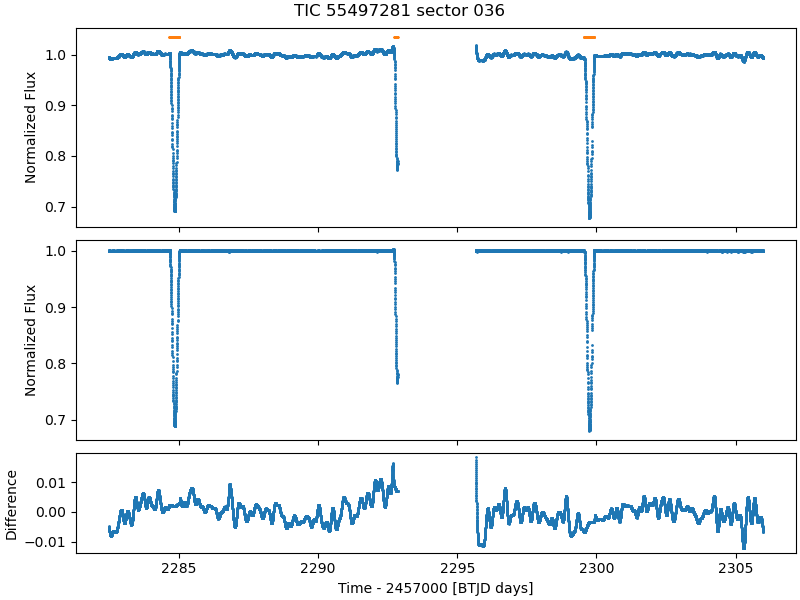

Sector 037...normalizing...creating mask...flattening...done.


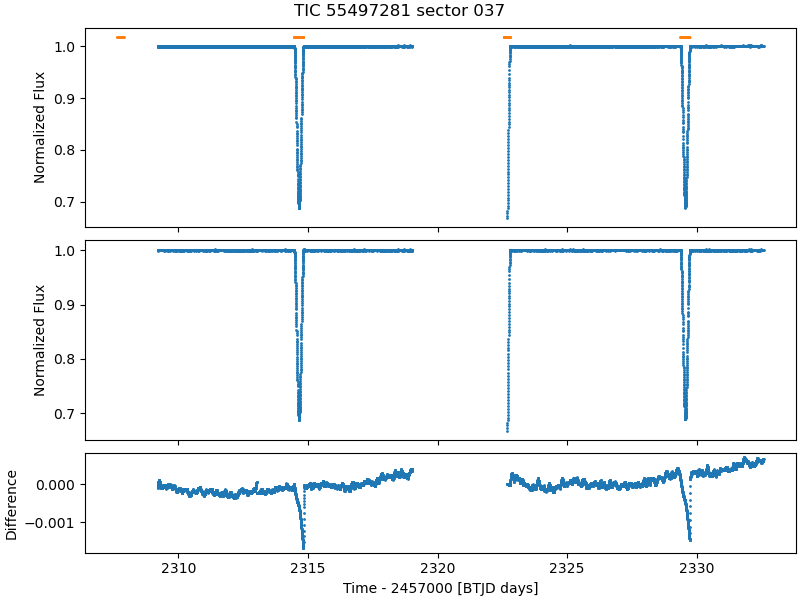

Sector 038...normalizing...creating mask...flattening...done.


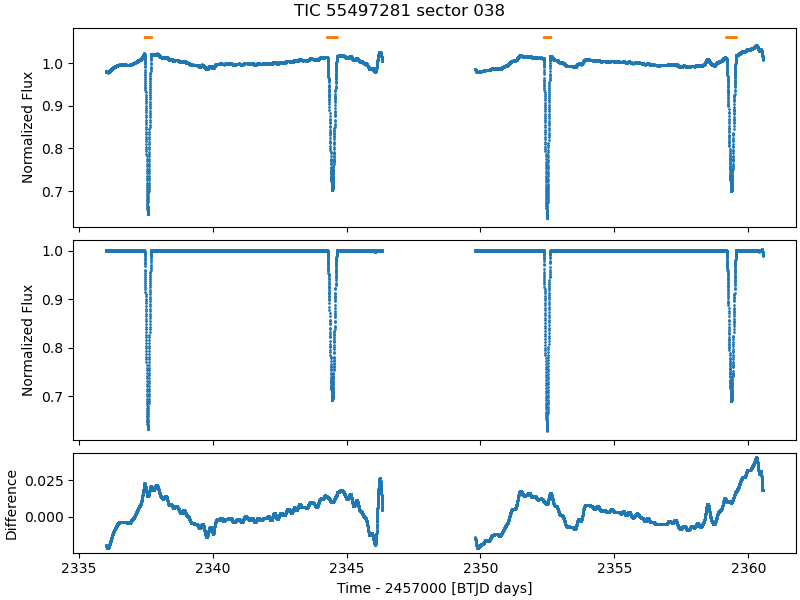

Sector 039...normalizing...creating mask...flattening...done.


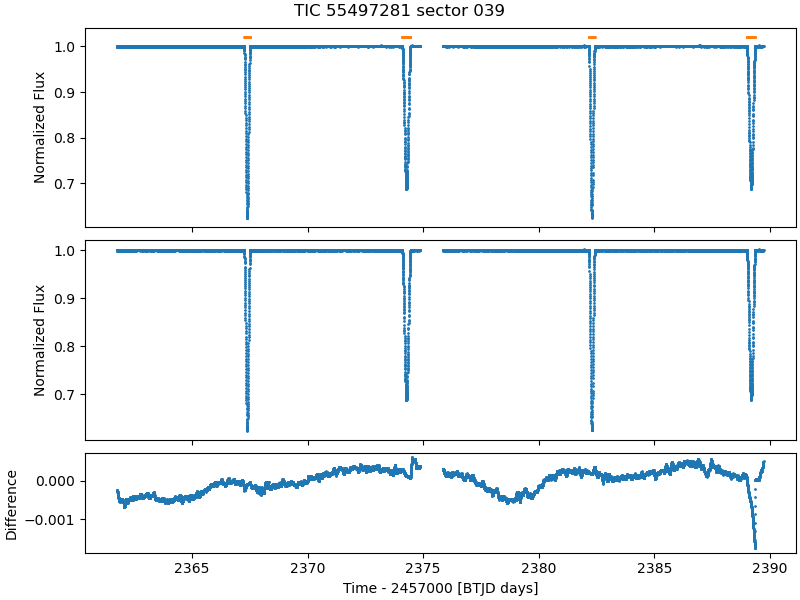

Sector 061...normalizing...creating mask...flattening...done.


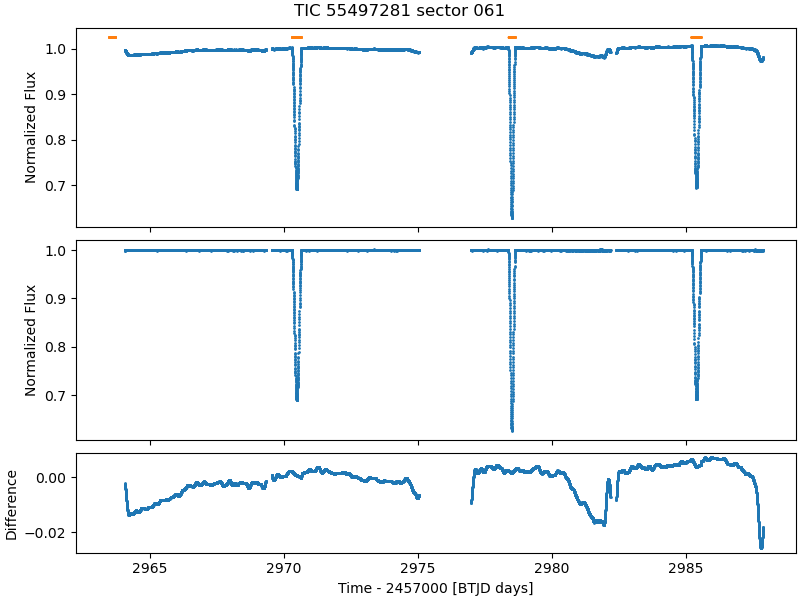

Sector 062...normalizing...creating mask...flattening...done.


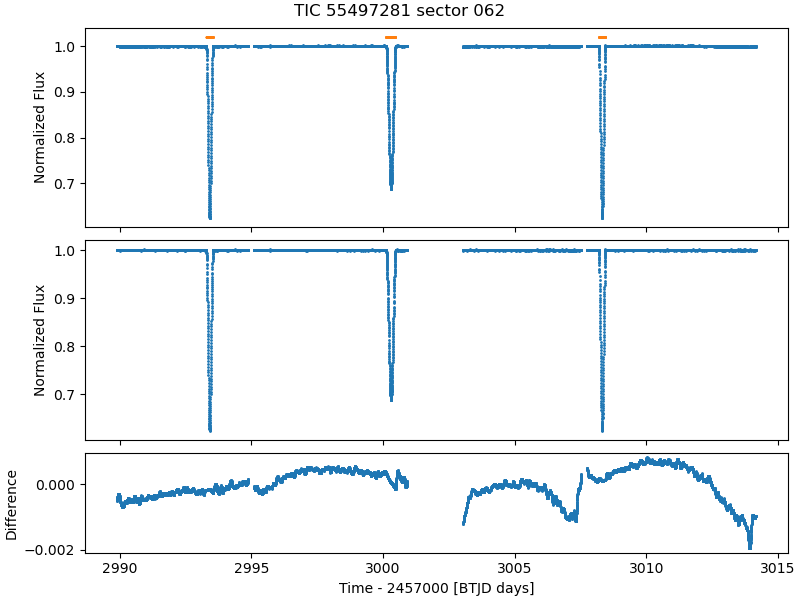

Sector 063...normalizing...creating mask...flattening...done.


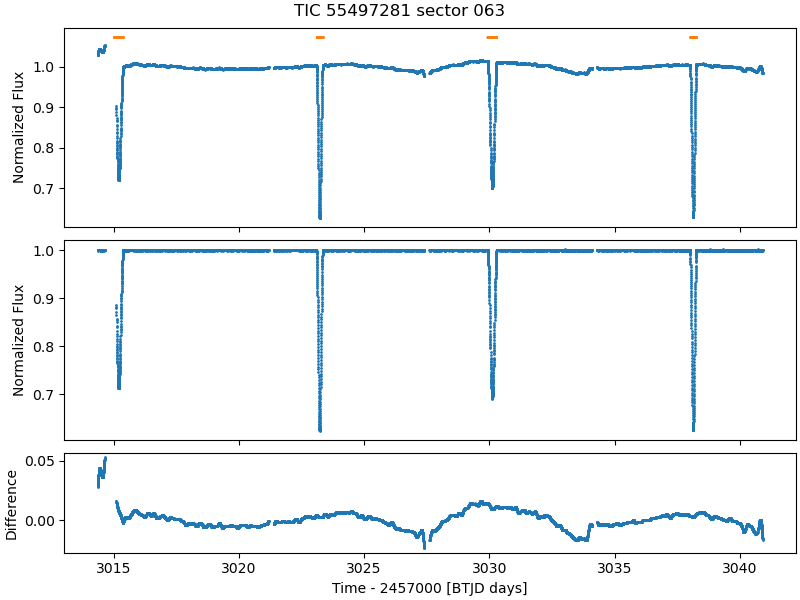

Sector 064...normalizing...creating mask...flattening...done.


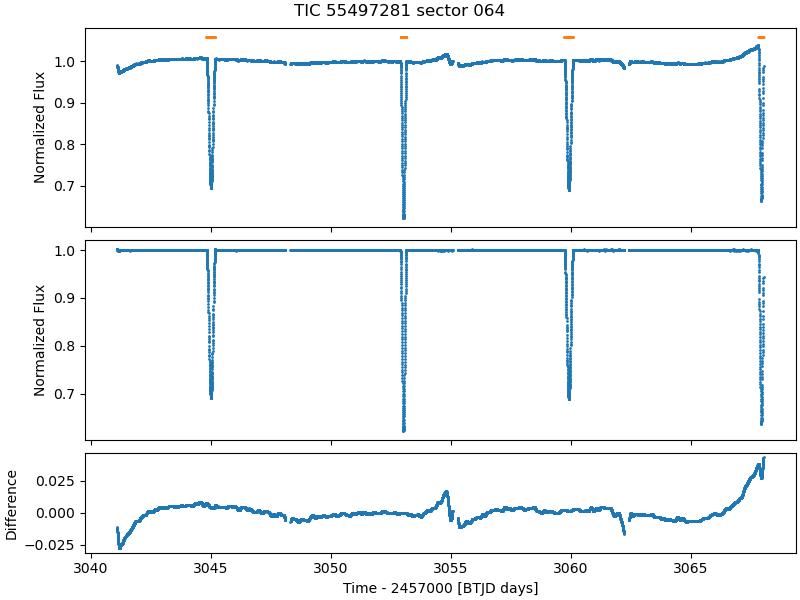

Sector 065...normalizing...creating mask...flattening...done.


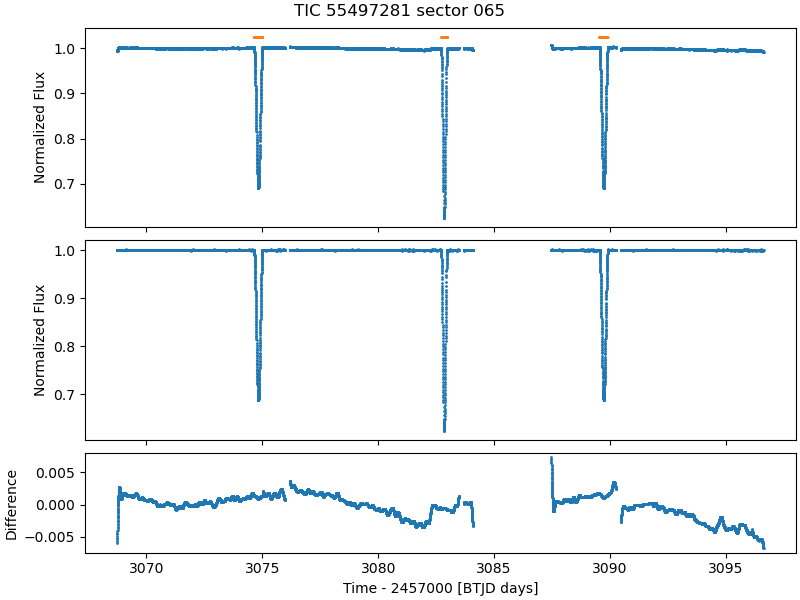

Sector 066...normalizing...creating mask...flattening...done.


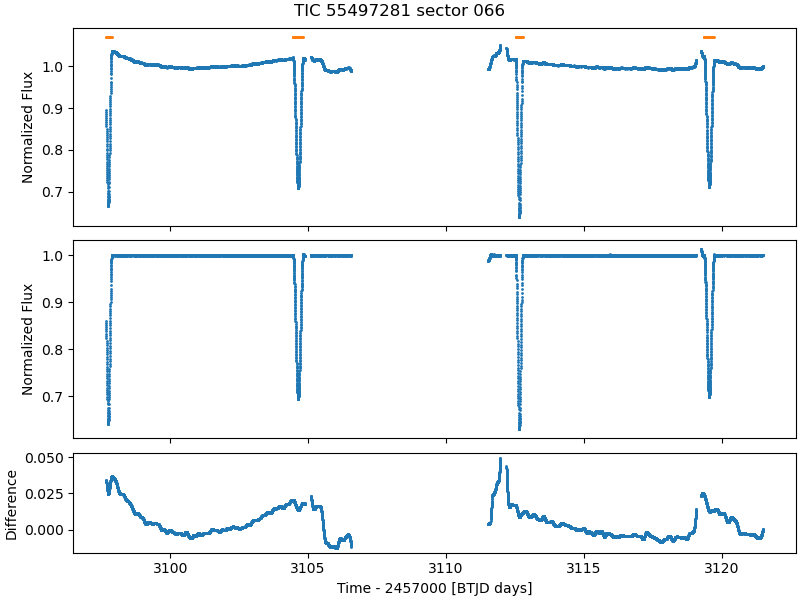

Sector 067...normalizing...creating mask...flattening...done.


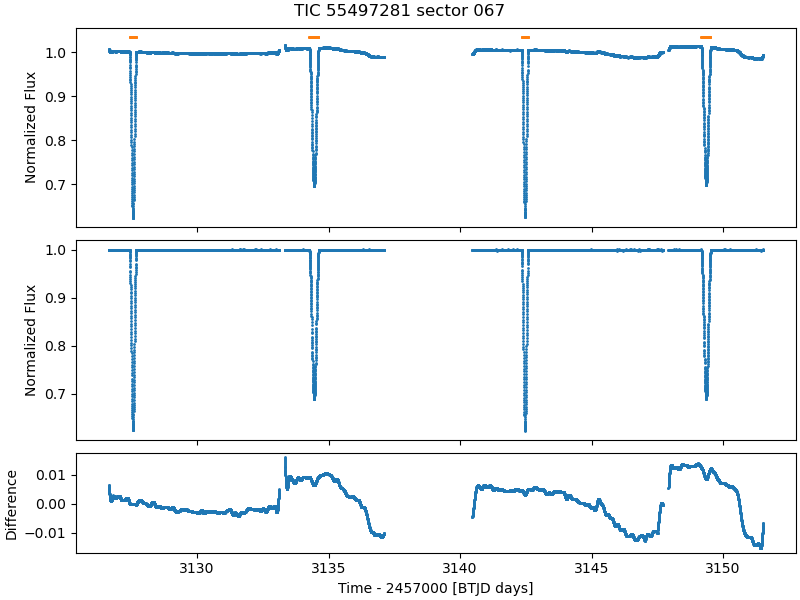

Sector 068...normalizing...creating mask...flattening...done.


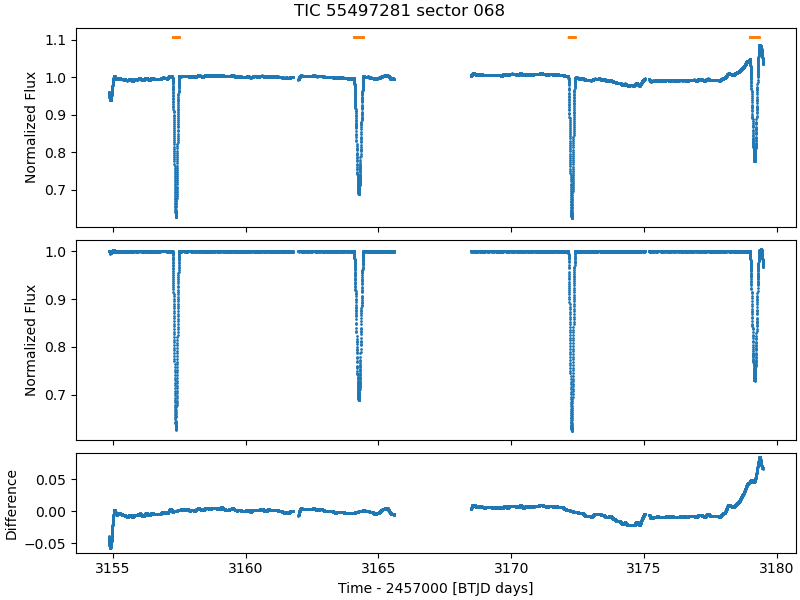

Sector 069...normalizing...creating mask...flattening...done.


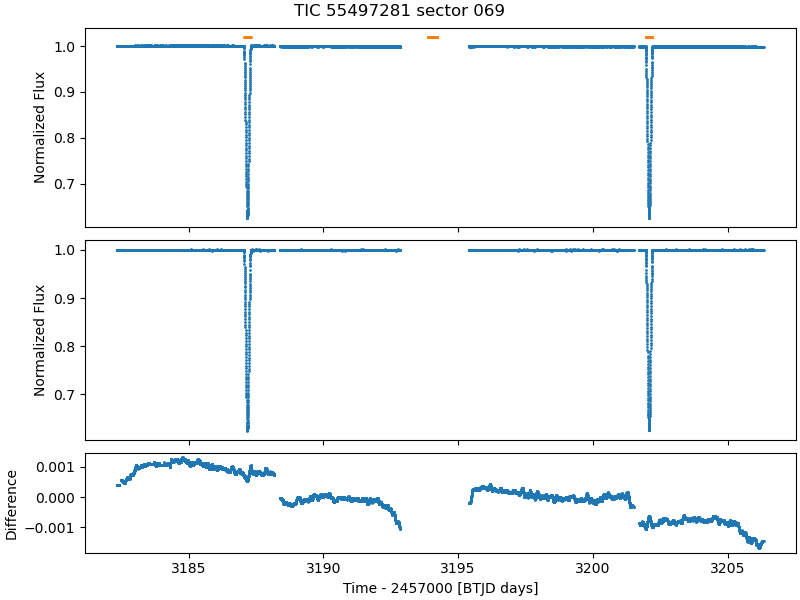

In [4]:
catalogue_dir = Path(".") / "catalogue"
analysis_dir = catalogue_dir / "analysis"
analysis_dir.mkdir(parents=True, exist_ok=True)

# TODO: lots of code duplicating parse_results module - set up shared functions

# find the target's basic details
input_df = pd.read_csv(input_file, index_col="Star")
target_row = input_df.loc[target]
if target_row is not None:
    tic = target_row["TIC"]

    # We need the analysis output, as that contains the eclipse timing data
    analysis_csv = analysis_dir / f"{tic}_analysis" / f"{tic}_analysis_summary.csv"
    if not analysis_csv.exists():
        print(f"Did not find analysis summary csv: {analysis_csv}")
        print(f"Unable to flatten {target}.")
    else:
        print("Analysis Log:")
        with (analysis_csv.parent / f"{tic}.log").open(mode="r") as lf:
            print("".join(lf.readlines()))

        summary = pd.read_csv(analysis_csv, sep=",", skiprows=2, 
                              names=["name", "val", "desc"], index_col="name")

        t0 = read_ufloat(summary, "t_mean")
        period = read_ufloat(summary, "period", "p_err")

        eclipse_times = [
            t0 + read_ufloat(summary, "t_1"),
            t0 + read_ufloat(summary, "t_2")
        ]

        eclipse_durations = [
            (read_ufloat(summary, "t_1_2") - read_ufloat(summary, "t_1_1")) * eclipse_dur_multiple,
            (read_ufloat(summary, "t_2_2") - read_ufloat(summary, "t_2_1")) * eclipse_dur_multiple
        ]

        print("From analysis summary")
        print(f"Reference time:          {t0:.6f}")
        print(f"Orbital period:          {period:.6f}")
        print(f"Reference clipse times: ", ", ".join(f"{t:.6f}" for t in eclipse_times))
        print(f"Eclipse durations:      ", ", ".join(f"{t:.6f}" for t in eclipse_durations))

        if any(t.nominal_value == 0 for t in eclipse_durations):
            print("At least one duration is zero - were eclipses found?")
        print()
        
        # Load, filter and then process the requested sectors for this target.
        target_dir = catalogue_dir / f"download/{tic:010d}/"
        fits = sorted(target_dir.rglob("**/*.fits"))
        lcs = lk.LightCurveCollection([
            lk.read(f"{f}", flux_column=flux_column, quality_bitmask=quality_bitmask) for f in fits])
        print(f"Loaded {len(lcs)} light curve fits file(s) for {target}.")
        for lc in [l for l in lcs if len(sectors) == 0 or l.sector in sectors]:

            sector = lc.meta["SECTOR"]
            print(f"Sector {sector:03d}...", end="")

            gridspec_kw = { "height_ratios": [4, 4, 2] }
            fig, axes = plt.subplots(3, 1, sharex="all", figsize=(8, 6), 
                                     gridspec_kw=gridspec_kw, constrained_layout=True)
            axes = axes.flatten()
            fig.suptitle(f"{lc.meta['OBJECT']} sector {sector:03d}")

            # Optionally normlize
            print("normalizing...", end="")
            lc = lc.normalize()

            # We can plot the raw LC in the upper ax
            lc.scatter(ax=axes[0], label=None)
            axes[0].set_xlabel(None)

            # Work out the eclipse mask for this sector
            print("creating mask...", end="")
            transit_mask = lc.create_transit_mask(
                transit_time=[t.nominal_value for t in eclipse_times],
                duration=[t.nominal_value for t in eclipse_durations],
                period=[period.nominal_value, period.nominal_value])   

            # Plot the masks above the LC in the upper ax
            masked_times = lc.time[transit_mask].value
            masked_flux = [axes[0].get_ylim()[1]] * len(masked_times)
            axes[0].scatter(x=masked_times, y=masked_flux, marker=".", s=1.)

            # Produce the flattened LC, based on the mask, and plot on lower ax
            print("flattening...", end="")
            flat_lc = lc.flatten(mask=transit_mask)
            flat_lc.scatter(ax=axes[1], label=None)
            axes[1].set_xlabel(None)

            res_lc = lc - flat_lc
            res_lc.scatter(ax=axes[2], label=None)
            axes[2].set_ylabel("Difference")

            print("done.")
            plt.show()

In [5]:
plt.close()